In [7]:
import torchvision.transforms as transforms
import plotly.graph_objs as go
import numpy as np
import PIL
import torchvision.transforms as T

import medmnist
from medmnist import INFO

In [2]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.1 @ https://github.com/MedMNIST/MedMNIST/


## General Observations
- `CHESTMnist` dataset is a multi-label dataset: https://github.com/MedMNIST/MedMNIST/issues/53. A multilabel classifier should be used to predict the labels of the images.
- There are imbalanced datasets in our analysis. To evaluate the performance of the models, both AUROC scores and accuracies in downstream tasks should be reported. For training the classifiers in these tasks, we can use both the original imbalanced dataset and a balanced version created through class-balanced sampling.

#### We work on a 2D dataset with size 64x64.

In [3]:
data_flag = 'pathmnist'
download = True

ROOT = "datasets/medmnist"  # Change if your dataset is stored elsewhere
SIZE = 64
NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [215]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download, root=ROOT, size=SIZE)
val_dataset = DataClass(split='val', transform=data_transform, download=download, root=ROOT, size=SIZE)
# test_dataset = DataClass(split='test', transform=data_transform, download=download, root=ROOT, size=SIZE)

Using downloaded and verified file: datasets/medmnist\pathmnist_64.npz
Using downloaded and verified file: datasets/medmnist\pathmnist_64.npz


In [216]:
print(train_dataset)
print("===================")
print(val_dataset)

Dataset PathMNIST of size 64 (pathmnist_64)
    Number of datapoints: 89996
    Root location: datasets/medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE

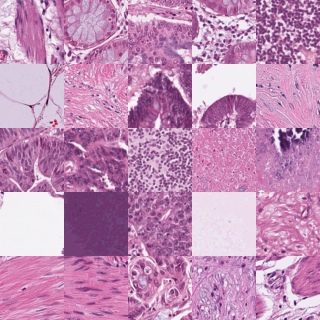

In [217]:
train_dataset.montage(length=5)

In [231]:
# get number of samples for each class in training set

def get_label_distribution(dataset, labels):
    label_count = {}
    for idx in dataset.labels:
        if(idx.shape == (1,)):
            label = labels[str(idx.item())]
            if label in label_count:
                label_count[label] += 1
            else:
                label_count[label] = 1
        else:  # multi-label
            for i in range(len(idx)):
                if idx[i] == 1:
                    label = labels[str(i)]
                    if label in label_count:
                        label_count[label] += 1
                    else:
                        label_count[label] = 1
    return label_count

train_labels = get_label_distribution(train_dataset, info['label'])
val_labels = get_label_distribution(val_dataset, info['label'])

In [232]:
train_labels, val_labels

({'adipose': 9366,
  'mucus': 8006,
  'cancer-associated stroma': 9401,
  'smooth muscle': 12182,
  'colorectal adenocarcinoma epithelium': 12885,
  'lymphocytes': 10401,
  'debris': 10360,
  'background': 9509,
  'normal colon mucosa': 7886},
 {'smooth muscle': 1354,
  'adipose': 1041,
  'background': 1057,
  'cancer-associated stroma': 1045,
  'mucus': 890,
  'lymphocytes': 1156,
  'colorectal adenocarcinoma epithelium': 1432,
  'normal colon mucosa': 877,
  'debris': 1152})

##### The dataset is partitioned into training and validation subsets while preserving the class distribution ratios. Consequently, visualizing the class distribution using either the training set, the validation set, or a combination of both, will be representative of the entire dataset (excluding the test set). The test set is regarded as an independent collection of samples that will only be seen once during the downstream task. Therefore, the test set is excluded from any analysis or manipulation in this notebook.

##### First, we'll show that it is the case for PATHMnist dataset. Afterwards, we'll be visualizing the class distribution of the combination of training and validation sets. 

In [233]:
val_labels = dict(sorted(val_labels.items(), key=lambda item: item[1]))
train_labels = dict(sorted(train_labels.items(), key=lambda item: item[1]))

labels = list(val_labels.keys())
inner = list(val_labels.values())
outer = list(train_labels.values())

trace1 = go.Pie(
    name="Validation set",
    hole=0.4,
    sort=True,
    direction='clockwise',
    values=inner,
    labels=labels,
    textinfo='none',
    hovertemplate = "%{label} <br>Percentage: %{percent} </br>Count: %{value}",
    title="PATHMnist",
    titleposition="middle center"
)

trace2 = go.Pie(
    name="Training set",
    hole=0.7,
    sort=True,
    direction='clockwise',
    values=outer,
    labels=labels,
    textinfo='value+percent',
    textposition='outside',
    marker={'colors': ['green', 'red', 'blue'],
            'line': {'color': 'white', 'width': 1}},
    hovertemplate = "%{label} <br>Percentage: %{percent} </br>Count: %{value}"
)

fig = go.FigureWidget(data=[trace1, trace2], layout=go.Layout(title="Label distribution in training and validation sets:<br>Inner: Validation set, Outer: Training set"))
fig.show()

In [234]:
# combine val_values and train_values
val_train_labels = {k: val_labels[k] + train_labels[k] for k in val_labels.keys()}
val_train_labels =  dict(sorted(val_train_labels.items(), key=lambda item: item[1]))
val_train_labels


{'normal colon mucosa': 8763,
 'mucus': 8896,
 'adipose': 10407,
 'cancer-associated stroma': 10446,
 'background': 10566,
 'debris': 11512,
 'lymphocytes': 11557,
 'smooth muscle': 13536,
 'colorectal adenocarcinoma epithelium': 14317}

In [235]:
pull = [0.1] + [0] * (len(val_train_labels) - 2) + [0.1]  # pull out the largest and smallest slices

trace = go.Pie(
    name="Training + Validation Set",
    sort=True,
    direction='clockwise',
    values=list(val_train_labels.values()),
    labels=list(val_train_labels.keys()),
    textinfo='value+percent',
    textposition='outside',
    marker={'colors': ['green', 'red', 'blue'],
            'line': {'color': 'white', 'width': 1}},
    hovertemplate = "%{label} <br>Percentage: %{percent} </br>Count: %{value}",
    pull=pull
)
fig = go.FigureWidget(data=[trace], layout=go.Layout(title="Label distribution in training + validation set"))
fig.show()

In [236]:
def visualize_class_distribution(flag):
    info = INFO[flag]
    task = info['task']
    n_channels = info['n_channels']
    n_classes = len(info['label'])

    DataClass = getattr(medmnist, info['python_class'])
    # preprocessing
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[.5], std=[.5])
    ])

    # load the data
    train_dataset = DataClass(split='train', transform=data_transform, download=download, root=ROOT, size=SIZE)
    val_dataset = DataClass(split='val', transform=data_transform, download=download, root=ROOT, size=SIZE)
    # test_dataset = DataClass(split='test', transform=data_transform, download=download, root=ROOT, size=SIZE)

    display(train_dataset.montage(length=5))
    train_labels = get_label_distribution(train_dataset, info['label'])
    val_labels = get_label_distribution(val_dataset, info['label'])
    val_train_labels = {k: val_labels[k] + train_labels[k] for k in val_labels.keys()}
    val_train_labels =  dict(sorted(val_train_labels.items(), key=lambda item: item[1]))
    
    pull = [0.1] + [0] * (len(val_train_labels) - 2) + [0.1]  # pull out the largest and smallest slices
    trace = go.Pie(
        name="Training + Validation Set",
        sort=True,
        direction='clockwise',
        values=list(val_train_labels.values()),
        labels=list(val_train_labels.keys()),
        textinfo='value+percent',
        textposition='outside',
        marker={'colors': ['green', 'red', 'blue'],
                'line': {'color': 'white', 'width': 1}},
        hovertemplate = "%{label} <br>Percentage: %{percent} </br>Count: %{value}",
        pull=pull
    )
    fig = go.FigureWidget(data=[trace], layout=go.Layout(title=f"{flag} training + validation set"))
    fig.show()


Using downloaded and verified file: datasets/medmnist\pathmnist_64.npz
Using downloaded and verified file: datasets/medmnist\pathmnist_64.npz


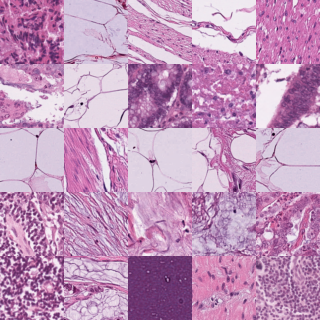

Using downloaded and verified file: datasets/medmnist\chestmnist_64.npz
Using downloaded and verified file: datasets/medmnist\chestmnist_64.npz


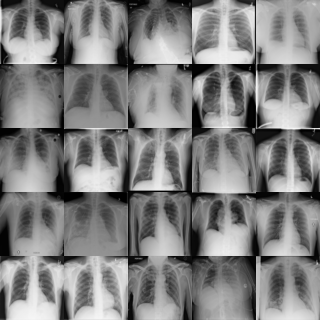

Using downloaded and verified file: datasets/medmnist\dermamnist_64.npz
Using downloaded and verified file: datasets/medmnist\dermamnist_64.npz


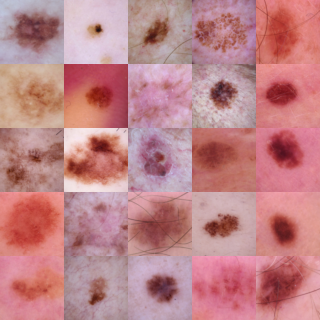

Using downloaded and verified file: datasets/medmnist\octmnist_64.npz
Using downloaded and verified file: datasets/medmnist\octmnist_64.npz


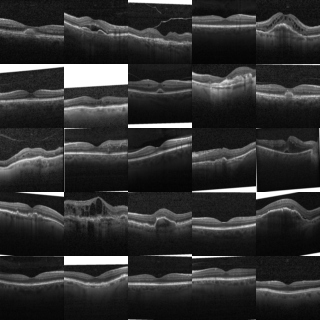

Using downloaded and verified file: datasets/medmnist\pneumoniamnist_64.npz
Using downloaded and verified file: datasets/medmnist\pneumoniamnist_64.npz


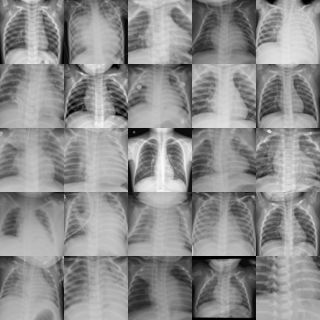

Using downloaded and verified file: datasets/medmnist\retinamnist_64.npz
Using downloaded and verified file: datasets/medmnist\retinamnist_64.npz


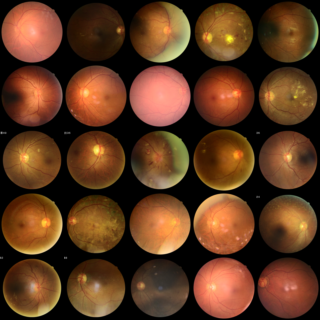

Using downloaded and verified file: datasets/medmnist\breastmnist_64.npz
Using downloaded and verified file: datasets/medmnist\breastmnist_64.npz


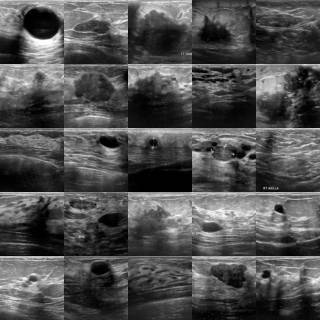

Using downloaded and verified file: datasets/medmnist\bloodmnist_64.npz
Using downloaded and verified file: datasets/medmnist\bloodmnist_64.npz


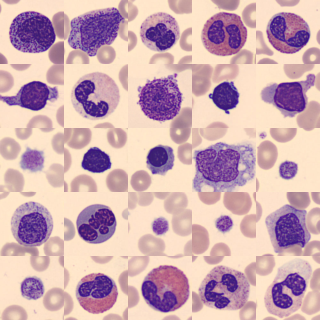

Using downloaded and verified file: datasets/medmnist\tissuemnist_64.npz
Using downloaded and verified file: datasets/medmnist\tissuemnist_64.npz


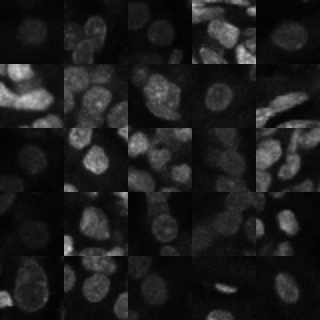

Using downloaded and verified file: datasets/medmnist\organamnist_64.npz
Using downloaded and verified file: datasets/medmnist\organamnist_64.npz


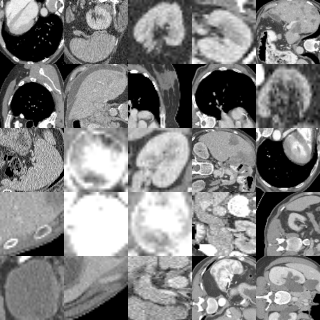

Using downloaded and verified file: datasets/medmnist\organcmnist_64.npz
Using downloaded and verified file: datasets/medmnist\organcmnist_64.npz


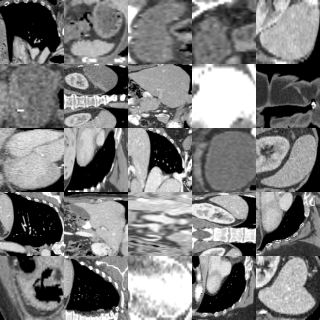

Using downloaded and verified file: datasets/medmnist\organsmnist_64.npz
Using downloaded and verified file: datasets/medmnist\organsmnist_64.npz


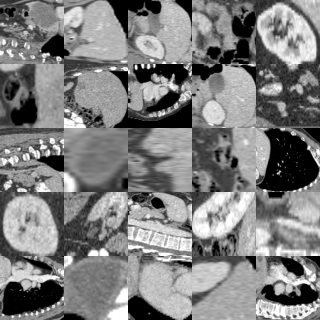

In [237]:
data_flags = ['pathmnist', 'chestmnist', 'dermamnist', 'octmnist', 'pneumoniamnist', 'retinamnist', 'breastmnist', 'bloodmnist', 'tissuemnist', 'organamnist', 'organcmnist', 'organsmnist']
for flag in data_flags:
    visualize_class_distribution(flag)

### Augmentations

* This time we will be using 224x224 images to visualize the effect of augmentations. Our augmentations consist of 4 steps:
    * toRGB: Some datasets consist of grayscale images. This augmentation converts the grayscale images to RGB images for consistency.
    * RandomResizedCrop: This augmentation crops the image to a random size and aspect ratio. Suggested in SimCLR paper.
    * ColorJitter: Applies color distortion to the image. Suggested in SimCLR paper.
    * GaussianBlur: Applies Gaussian blur to the image. Suggested in SimCLR paper.
    * toTensor: Converts a `PIL Image` or `numpy.ndarray` $(H \times W \times C)$ in the range $[0, 255]$ to a `torch.FloatTensor` of shape $(C \times H \times W)$ in the range $[0, 1]$.
    * Normalization: Normalizes the image with the mean = 0.5, and standard deviation = 0.5. (Used in official MEDMnist [notebook](https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb)) 

100%|██████████| 3889293042/3889293042 [20:34<00:00, 3150819.04it/s] 


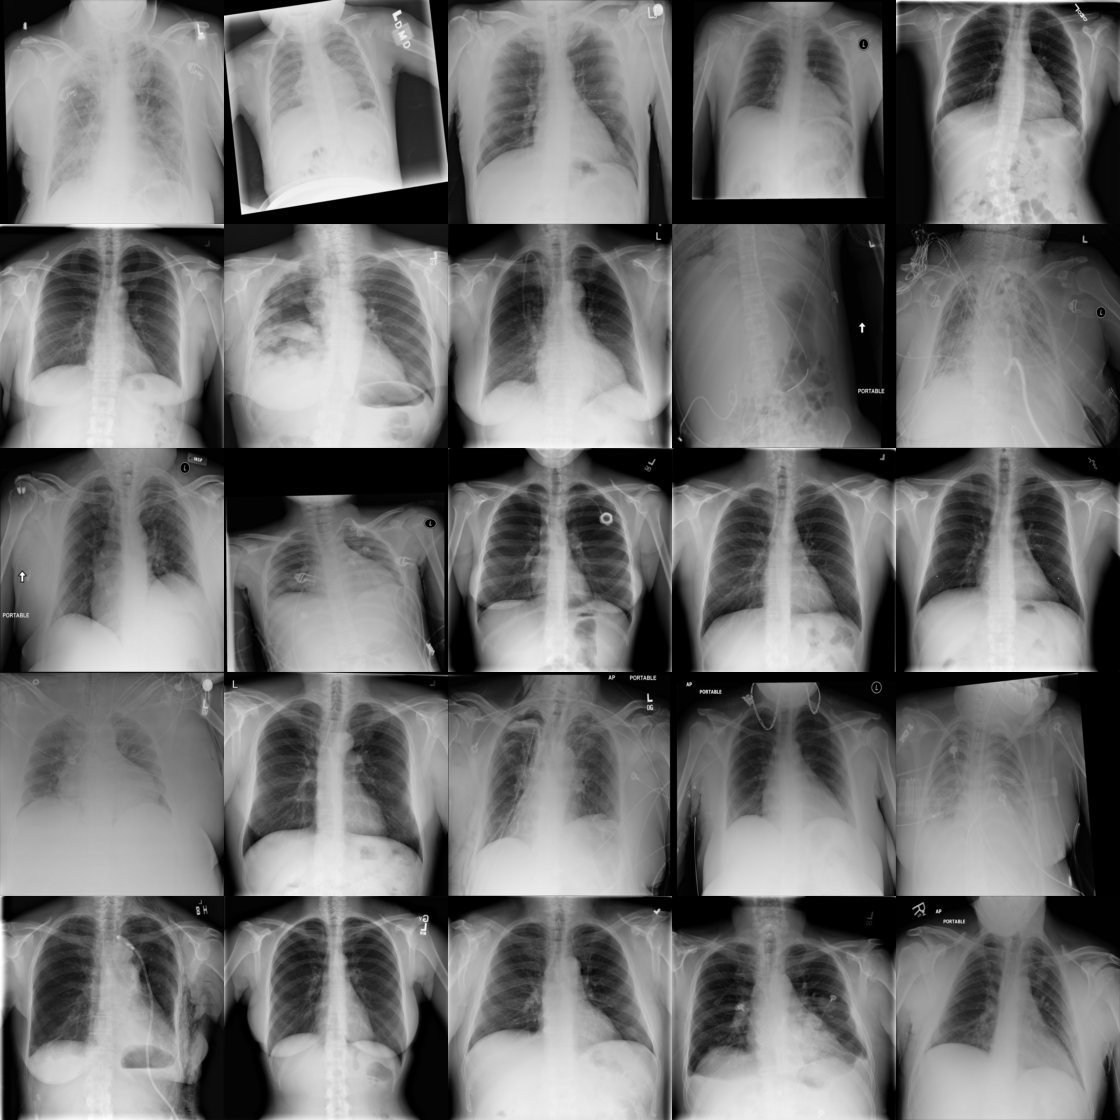

In [307]:
chestmnist = medmnist.ChestMNIST(split='train', transform=data_transform, download=download, root=ROOT, size=224)
chestmnist.montage(length=5)

In [25]:
def to_rgb(img):
    return img.convert("RGB")

# SIMCLR augmentation
augmentations = transforms.Compose(
            [
                # Normalise to 3 channels
                transforms.Lambda(to_rgb),
                # Transformation 1: crop-and-resize
                transforms.RandomResizedCrop(size=224),
                # Transformation 2: colour distortion
                transforms.RandomApply(
                    [
                        transforms.ColorJitter(
                            brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1
                        )
                    ],
                    p=0.8,
                ),
                # Transformation 3: Gaussian blur
                transforms.GaussianBlur(kernel_size=9),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
            ]
        )

In [311]:
chestmnist.imgs.shape

(78468, 224, 224)

In [324]:
def sample_images(dataset, num_samples=10):
    indices = np.random.randint(len(dataset), size=num_samples)
    images = [dataset[i] for i in indices]
    return images

def display_augmentations(img, augmentations):
    im1 = PIL.Image.fromarray(img)
    im1 = to_rgb(im1)
    augmented_img = augmentations(im1)
    im2 = T.ToPILImage()(augmented_img)
    
    display(PIL.Image.fromarray(np.hstack((np.array(im1),np.array(im2)))))

def pipeline(dataset, num_samples, augmentations):
    images = sample_images(dataset, num_samples)
    for img in images:
        display_augmentations(img, augmentations)

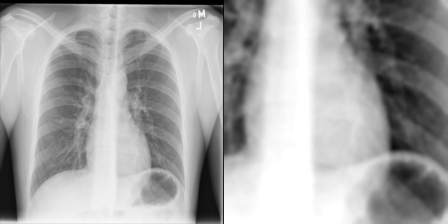

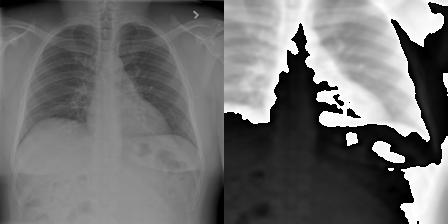

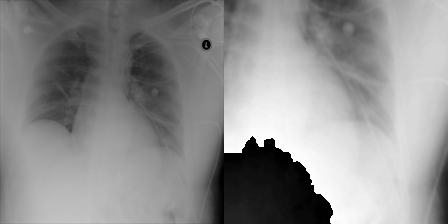

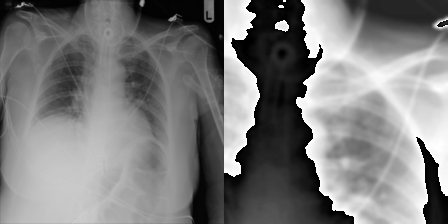

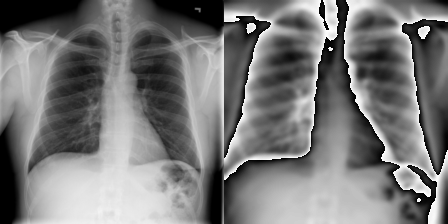

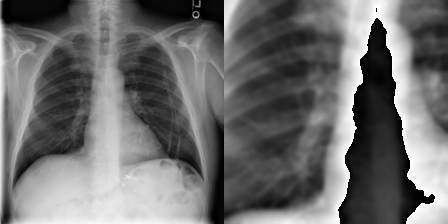

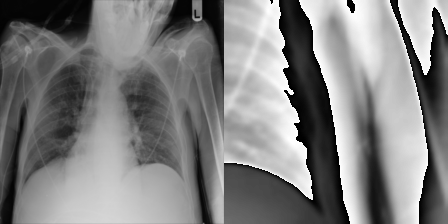

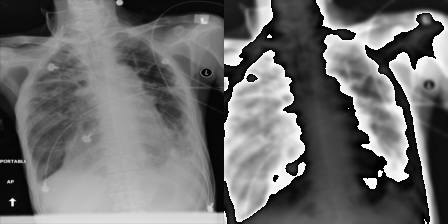

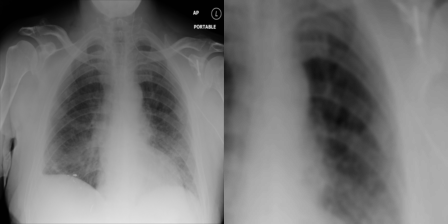

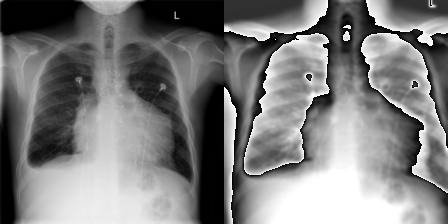

In [326]:
pipeline(chestmnist.imgs, 10, augmentations)